In [1]:
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import clear_output
import time
from csv import writer

# Funções básicas para implementação do jogo

In [4]:
# Funções que implementão o jogo

def accumulate(fn, initial, seq):
    if not seq:
        return initial
    else:
        return fn(seq[0], 
                  accumulate(fn, initial, seq[1:]))
    
def flatten(mat):
    return [num for row in mat for num in row]

def has_zero(mat):
    return 0 in flatten(mat)

def transpose(mat):
    return list(map(list,zip(*mat)))

def reverse(mat):
    return list(map(lambda row: list(reversed(row)),mat))


# Matriz do jogo

# Em 2048, o padrão é uma matriz 4x4 (n=4)
def new_game_matrix(n):
    matrix = []
    for i in range(n):
        matrix.append([0] * n)
    return matrix

# Função para adicionar o bloco "2" aleatoriamente em um local vazio (0)
# No jogo original, pode-se aparecer um 2 ou um 4 a 
def add_two(mat):
    if not has_zero(mat):
        return mat
    a = randint(0, len(mat)-1)
    b = randint(0, len(mat)-1)
    while mat[a][b] != 0:
        a = randint(0, len(mat)-1)
        b = randint(0, len(mat)-1)
    mat[a][b] = 2
    return mat

# Função para checar o status do jogo
def game_status(mat):
#     for row in mat:
#         for element in row:
#             if element == 8192:
#                 return 'win'

    if has_zero(mat): #Se ainda tiver espaços vazios
        return 'not over'
    for i in range(len(mat)): #Checa por movimentos possíveis na horizontal
        for j in range(len(mat[0])-1):
            if mat[i][j] == mat[i][j+1]:
                return 'not over'
    for i in range(len(mat)-1): #Checa por movimentos possíveis na horizontal
        for j in range(len(mat[0])):
            if mat[i][j] == mat[i+1][j]:
                return 'not over'
    return 'lose'

#Mover a esquerda
def merge_left(matrix):
    def merge_row(row):
        merged_row, prev_tile, score_increment = [], 0, 0
        # pack element by element left-wards
        for tile in row:
            if tile == 0: continue
            if prev_tile == 0:
                prev_tile = tile
            elif prev_tile != tile:
                merged_row.append(prev_tile)
                prev_tile = tile
            else:
                merged_row.append(prev_tile*2)
                score_increment += prev_tile*2
                prev_tile = 0
        merged_row.append(prev_tile) # valid regardless whether there are merges or not
        # top up zeros
        while len(merged_row) != len(row):
            merged_row.append(0)
        return (merged_row, merged_row != row, score_increment)

    return accumulate(lambda first, rest: ([first[0]] + rest[0], 
                                            first[1] or rest[1], 
                                            first[2] + rest[2]),
                      ([], False, 0),
                      list(map(merge_row, matrix)))
#Mover a direita
def merge_right(mat):
    mat, valid, score = merge_left(reverse(mat))
    return (reverse(mat), valid, score)

#Mover pra cima
def merge_up(mat):
    mat, valid, score = merge_left(transpose(mat))
    return (transpose(mat), valid, score)

#Mover pra baixo
def merge_down(mat):
    mat, valid, score = merge_left(reverse(transpose(mat)))
    return (transpose(reverse(mat)), valid, score)


                
def make_new_record(mat, score):
    return (mat, score)
def get_record_matrix(record):
    return record[0]
def get_record_score(record):
    return record[1]




def new_records():
    return []
def add_record(new_record, records):
    NUM_OF_UNDOS = 3
    records.append(new_record)
    if num_of_records(records) > NUM_OF_UNDOS:
        records = records[-NUM_OF_UNDOS:]
    return records
def num_of_records(records):
    return len(records)
def is_empty(records):
    return num_of_records(records) <= 0
def pop_last_record(records):
    if not is_empty(records):
        last_record = records.pop()
        return (get_record_matrix(last_record),
                get_record_score(last_record),
                records)
    else:
        return (None, None, records)



def make_state(matrix, total_score, history):
    return (matrix, total_score, history)
def get_matrix(state):
    return state[0]
def get_score(state):
    return state[1]
def get_history(state):
    return state[2]
def make_new_game(n):
    starting_matrix = add_two(add_two(new_game_matrix(n)))
    return make_state(starting_matrix, 0, new_records())

def execute_move(state, matrix_updater):   
    current_score = get_score(state)
    next_matrix, valid_move, score_increment = matrix_updater(get_matrix(state))
    if not valid_move:
        return (state, False)
    else:
        updated_history = ()
        updated_state = make_state(add_two(next_matrix),
                                   current_score + score_increment,
                                   updated_history)
        return (updated_state, True)
def left(state):
    return execute_move(state, merge_left)
def right(state):
    return execute_move(state, merge_right)
def up(state):
    return execute_move(state, merge_up)
def down(state):
    return execute_move(state, merge_down)

def undo(state):
    records = get_history(state)
    matrix, score, records = pop_last_record(records)
    if matrix:
        return (make_state(matrix, score, records), True)
    else:
        return (state, False)    

game_logic = {
    'make_new_game': make_new_game,
    'game_status': game_status,
    'get_score': get_score,
    'get_matrix': get_matrix,
    'up': up,
    'down': down,
    'left': left,
    'right': right,
    'undo': undo
}

def random_move(current_state):
    index = np.random.randint(4)
    return ["up", "down", "left", "right"][index]

In [5]:
# Função para visualização do tabuleiro
def printboardstate(boardstate, moveMade=""):
        mat, score, _ = boardstate
        arr = np.array(mat)
        max_block = np.max(arr)  

        cmap_dict = {
        2: '#EEE4DA',
        4: '#EDE0C8',
        8: '#F2B179',
        16: '#F59563',
        32: '#F67C60',
        64: '#F65E3B',
        128: '#EDCF73',
        256: '#EDCC62',
        512: '#EDC850',
        1024: '#EDC53F',
        2048: '#EDC22D',
        4096: '#3D3A33'
        }

        cmap_colors = list(cmap_dict.values())
        norm = colors.LogNorm(vmin=0, vmax=2048, clip=False)
        cmap = colors.LinearSegmentedColormap.from_list('log_cmap', cmap_colors)

        log_vmin = 2
        log_vmax = 4096

        sns.heatmap(mat, annot = True, 
        square = True, cbar = False, cmap = cmap, norm=colors.LogNorm(vmin=log_vmin, vmax=log_vmax),vmin=0, vmax=4096, fmt = 'd')
        sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'white'})

        #sns.heatmap(mat, annot = True, 
        #square = True, cbar = False, cmap = 'YlOrBr', fmt = 'd')
        #plt.title("2048 - Maior bloco: " + str(max_block) + " | Score:  " + str(score))

        if moveMade=="up":
                showMove = "↑" 
        elif moveMade=="down":
                showMove = "↓"                         
        elif moveMade=="left":
                showMove = "←"  
        elif moveMade=="right":
                showMove = "→ " 
        else:
                showMove = ""                

        if showMove == "":
                plt.title("2048 - Maior bloco: " + str(max_block) + " | Score:  " + str(score))
        else:
                plt.title("2048 - Maior bloco: " + str(max_block) + " | Score:  " + str(score) + " | Movimento: " + str(showMove))
                
        plt.axis('off')
        plt.show()

# Simulação de um jogo aleatório

Partindo de um estado inicial, realiza ações completamente aleatórias até que obtenha-se um "game-over"

Estado final:


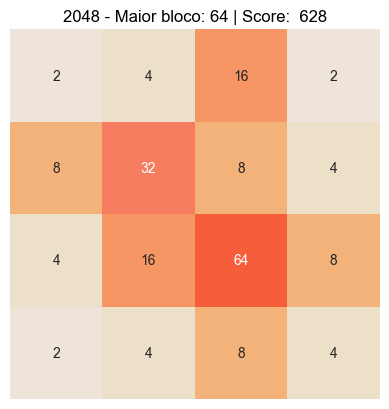

Movimentos feitos: 113
Tempo de execução: 1.9836ms


In [6]:
#Jogo aleatório completo até o game-over
current_state = make_new_game(4)

#print('Initial state:')
#printboardstate(current_state)
movesMade = 0
gameStartTime = time.time()
while game_status(get_matrix(current_state)) == "not over":
    movesMade += 1
    best_move = random_move(current_state)
    best_move = game_logic[best_move]
    current_state, _ = best_move(current_state)
gameEndTime = time.time()    
print('Estado final:')
printboardstate(current_state)
print('Movimentos feitos: ' + str(movesMade))
print("Tempo de execução: " + str(np.round(1000*(gameEndTime - gameStartTime), 4))+ "ms")

## Visualização de jogo aleatório em tempo real
Aplicado um delay gradativo através da função time.sleep. Caso deseje visualizar mais rapidamente, reduzir os tempos de espera

Tabuleiro atual


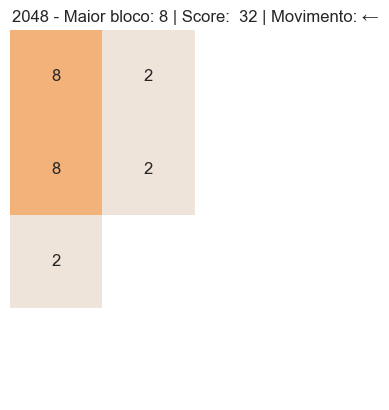

Movimentos feitos: 10


KeyboardInterrupt: 

In [7]:
# Jogo completamente aleatório em tempo real
current_state = make_new_game(4)

print('Initial state:')
printboardstate(current_state)
movesMade = 0

while game_status(get_matrix(current_state)) == "not over":
    clear_output(wait=True)
    movesMade += 1
    best_move = random_move(current_state)
    moveMade = best_move
    best_move = game_logic[best_move]
    current_state, _ = best_move(current_state)
    print('Tabuleiro atual')
    #print('Movimento realizado: ' + str(moveMade))
    printboardstate(current_state, moveMade)
    print('Movimentos feitos: ' + str(movesMade))
    if 0<= movesMade <25:
        time.sleep(1)
    elif 25<= movesMade <50:
        time.sleep(0.5)        
    elif 50<= movesMade <75:
        time.sleep(0.3)
    else:
        time.sleep(0.2)
    
    
print('Tabuleiro final:')
printboardstate(current_state)
print('Movimentos feitos: ' + str(movesMade))

# Monte Carlo AI

Realiza a exploração aleatória do espaço de estados para cada um dos movimentos possíveis através de simulações e então realiza aquele movimento que apresentou a maior média de score. 


In [8]:
# Função que gera jogo aleatório com base em um estado inicial
def playthrough(gamestate, num_tries, max_depth):
    #A partir de um GameState, joga usando movimentos aleatórios um número x = num_tries de vezes, expandindo até 10 estados por tentativa
    score = 0
    for i in range(num_tries):
        newstate = gamestate
        depth = 0
        while game_status(get_matrix(newstate)) == "not over" and depth<max_depth:
            best_move = random_move(newstate)
            best_move = game_logic[best_move]
            newstate, _ = best_move(newstate)
            
            depth += 1
        score += newstate[1]
    
    return score/num_tries

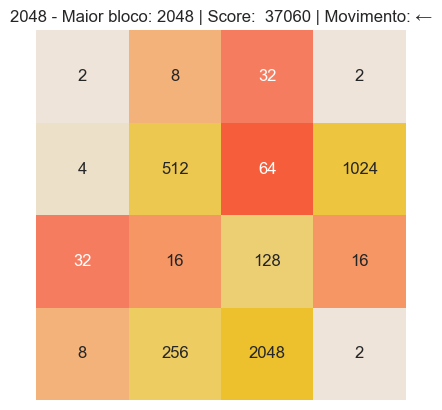

Maior bloco: 2048
Movimentos feitos: 2075
Tempo por movimento: 0.4971ms
Final state:


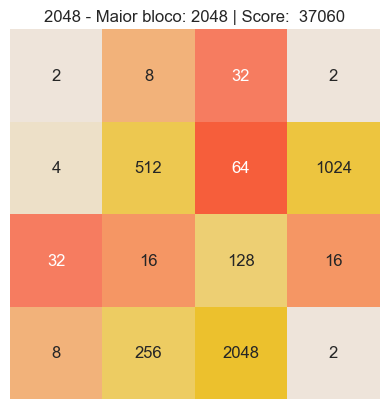

In [9]:
VISUALIZATION = True #Se for verdadeiro, realizará o plot gráfico do tabuleiro em tempo real
NUMTRIES = 100 #Número de tentativas por movimento
DEPTH = 10 #Número de nós/espaços expandidos por tentativa

initial_state = make_new_game(4)
# Pode-se iniciar o jogo manualmente, fornecendo o tabuleiro, score e históricos desejados 
# initial_state = ([[0, 0, 0, 0], [8, 2, 0, 0], [4, 0, 0, 0], [4, 64, 8, 2]], 348, ())

print('Initial state:')
printboardstate(initial_state)

num_tries = NUMTRIES
max_depth = DEPTH
    
current_state = initial_state
movesMade=0
while game_status(get_matrix(current_state)) == "not over":

    searchStartTime = time.time()
    # Only evaluate for valid moves
    bestscore = -1
    bestmove = ""
    
    for move in ['up', 'down', 'left', 'right']:
        _, valid = game_logic[move](current_state)
        if not valid: continue
        
        # perform monte carlo simulation for each of the valid moves
        montecarlo_state, _ = game_logic[move](current_state)
        montecarlo_score = playthrough(montecarlo_state, num_tries, max_depth)
        if montecarlo_score > bestscore:
            bestscore = montecarlo_score
            bestmove = move

    searchEndTime = time.time()

    # do the move with the highest score
    current_state, _ = game_logic[bestmove](current_state)
    movesMade += 1

    clear_output(wait=True)

    mat, score, _ = current_state
    arr = np.array(mat)
    max_block = np.max(arr)  
    if VISUALIZATION == True: 
        printboardstate(current_state, bestmove)

    print('Maior bloco: ' + str(max_block))
    print('Movimentos feitos: ' + str(movesMade)) 
    print('Tempo por movimento: '+ str(np.round(1000*(searchEndTime - searchStartTime), 4))+ "ms") 
    
    if VISUALIZATION == True: 
        time.sleep(0.2) 

    
print('Final state:')
printboardstate(current_state)


# Avaliação de performance

Executa-se multiplas vezes o jogo utilizando o algoritmo e armazena-se os resultados de pontuação obtidos para análises de performance. Foram realizados inicialmente 25 execuções, obtendo-se 92% de sucesso (obteve-se o block 2048 ou superior).

In [162]:
# Função para executar o jogo via busca de monte carlo e retornar o GameState
def runGameMC():


    initial_state = make_new_game(4)

    #print('Initial state:')
    #printboardstate(initial_state)

    num_tries = NUMTRIES
    max_depth = DEPTH
        
    current_state = initial_state
    movesMade=0
    while game_status(get_matrix(current_state)) == "not over":

        searchStartTime = time.time()
        # Only evaluate for valid moves
        bestscore = -1
        bestmove = ""
        
        for move in ['up', 'down', 'left', 'right']:
            _, valid = game_logic[move](current_state)
            if not valid: continue
            
            # perform monte carlo simulation for each of the valid moves
            montecarlo_state, _ = game_logic[move](current_state)
            montecarlo_score = playthrough(montecarlo_state, num_tries, max_depth)
            if montecarlo_score > bestscore:
                bestscore = montecarlo_score
                bestmove = move

        searchEndTime = time.time()

        # do the move with the highest score
        current_state, _ = game_logic[bestmove](current_state)
        movesMade += 1

        #clear_output(wait=True)
        print('Movimentos feitos: ' + str(movesMade), end="\r") 
        mat, score, _ = current_state
        arr = np.array(mat)
        max_block = np.max(arr)  

    return (current_state, movesMade)

# Roda o jogo usando MC um número X de vezes e salva os resultados em um arquivo CSV
NUMBEROFRUNS = 5
SAVEINCSV = True

NUMTRIES = 100 #Número de tentativas por movimento
DEPTH = 10 #Número de nós/espaços expandidos por tentativa


for i in range(NUMBEROFRUNS):
    print("Rodada de execução #" + str(i+1) + " de " + str(NUMBEROFRUNS)+ ":")
    gameStartTime = time.time()
    (iterationGameState, movesMade) = runGameMC()
    gameEndTime = time.time()

    mat, score, _ = iterationGameState
    arr = np.array(mat)
    max_block = np.max(arr)
    
    print()
    print("Score: " + str(score))
    print("Max block: " + str(max_block))
    print("Tempo de execução: " + str(np.round((gameEndTime - gameStartTime), 4))+ "s")
    print("Tempo médio por movimento: " + str(np.round(1000*(gameEndTime - gameStartTime)/movesMade, 4))+ "ms")
    print()

    if SAVEINCSV == True:
        with open('runs2.csv', 'a') as f_object:
            writer_object = writer(f_object)
    
            List = [score, max_block]

            writer_object.writerow(List)
            f_object.close()  



Rodada de execução #1 de 5:
Movimentos feitos: 2971
Score: 59824
Max block: 4096
Tempo de execução: 149.9064s
Tempo médio por movimento: 50.4566ms

Rodada de execução #2 de 5:
Movimentos feitos: 1984
Score: 35672
Max block: 2048
Tempo de execução: 99.3268s
Tempo médio por movimento: 50.0639ms

Rodada de execução #3 de 5:
Movimentos feitos: 1574
Score: 27932
Max block: 2048
Tempo de execução: 76.8549s
Tempo médio por movimento: 48.8278ms

Rodada de execução #4 de 5:
Movimentos feitos: 2040
Score: 36680
Max block: 2048
Tempo de execução: 101.1419s
Tempo médio por movimento: 49.5794ms

Rodada de execução #5 de 5:
Movimentos feitos: 1563
Score: 27824
Max block: 2048
Tempo de execução: 77.08s
Tempo médio por movimento: 49.3154ms

